In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

In [2]:
import functions as func

### Read data

In [3]:
df = pd.read_csv("Data/ECA_blended_custom/TG_STAID002759.txt", skiprows= 18, sep=',')
df.columns = ['SOUID', 'DATE','TG','Q_TG']
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day

df.set_index('DATE', inplace = True)

df['Celsius'] = df['TG'] * 0.1
df['Kelvin'] = df['Celsius'] + 273.15 

### Calculate percentage changes

In [4]:
df['pct_change'] = df.Kelvin.pct_change()

### Train-test split

In [5]:
df_train = df['1950':'2019']
df_test = df['2019':]

### Deseasonalize

In [6]:
df_train['monthly_means'] = df_train.groupby('month')['pct_change'].transform("mean")
df_train['pct_stationary'] = df_train['pct_change'] - df_train['monthly_means']

df_test['monthly_means'] = df_train['monthly_means']['2016':'30-06-2017'].values
df_test['pct_stationary'] = df_test['pct_change'] - df_test['monthly_means']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

### Feature Engineer 1st model with 3 time lags

In [7]:
print('4. Feature Engineering...\n')
X_train_fe = func.feature_engineer_Kelvin3(df_train)
X_test_fe = func.feature_engineer_Kelvin3(df_test)

4. Feature Engineering...



/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['t-1 K'] = data['Kelvin'].shift(1)
/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['t-2 K'] = data['Kelvin'].shift(2)
/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:20: SettingWithCopyWarning: 
A value i

In [8]:
X_train_fe.head()

,t-1 K,t-2 K,t-3 K
DATE,,,
1950-01-04,276.05,274.15,269.65
1950-01-05,273.05,276.05,274.15
1950-01-06,270.15,273.05,276.05
1950-01-07,275.45,270.15,273.05
1950-01-08,278.35,275.45,270.15


### Fit model

In [9]:
m = LinearRegression()
m.fit(X_train_fe, df_train['Kelvin'][3:])
#m.score(X_train_fe.dropna(), df_train['Kelvin'][3:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Make predictions

In [10]:
y_pred = m.predict(X_test_fe.dropna())

In [11]:
results3 = zip(df_test['Kelvin'][3:], y_pred)
results3 = pd.DataFrame(results3)
results3.columns = ['True Kelvin', 'pred']
results3.head()

,True Kelvin,pred
0,275.25,273.923120
1,279.25,276.046018
2,275.45,279.238664
3,276.45,274.870931
4,277.95,277.395705


### Check coefficients

In [12]:
m.coef_

array([ 1.0184593 , -0.22314917,  0.164587  ])

### Score model

In [13]:
rmse = np.sqrt(mean_squared_error(results3['True Kelvin'], results3['pred']))
rmse

2.23331546683865

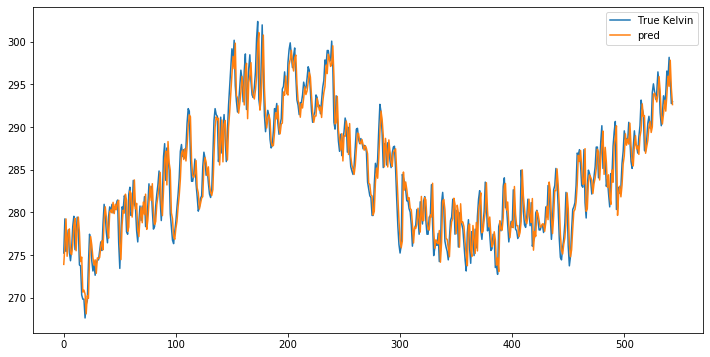

In [14]:
results3.plot()

### Compare with persistence

In [15]:
persistence = zip(df_test['Kelvin'][3:], df_test['Kelvin'][:].shift(1)[3:])
persistence = pd.DataFrame(persistence)
persistence.columns = ['True Kelvin', 'pred']
persistence.head()

,True Kelvin,pred
0,275.25,272.85
1,279.25,275.25
2,275.45,279.25
3,276.45,275.45
4,277.95,276.45


In [16]:
rmse = np.sqrt(mean_squared_error(persistence['True Kelvin'], persistence['pred']))
rmse

2.3406062248913204

### Does it make sense to try more time lags?

Figure(864x432)


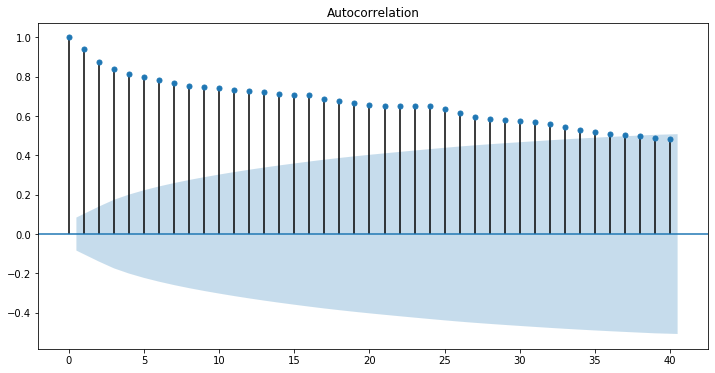

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

print(plot_acf(persistence['True Kelvin'], lags=40))

Figure(864x432)


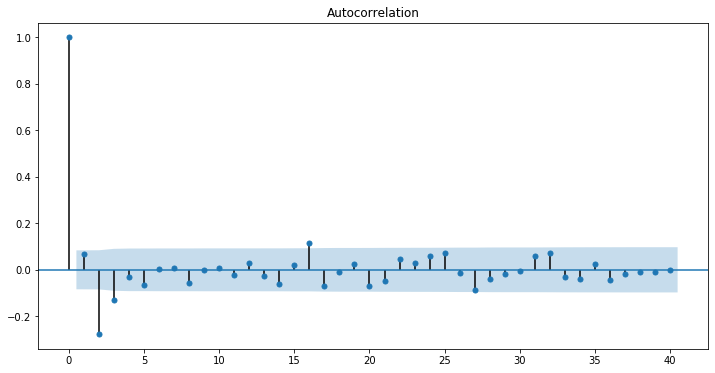

In [18]:
print(plot_acf(df_test['pct_stationary'], lags=40))

Figure(864x432)


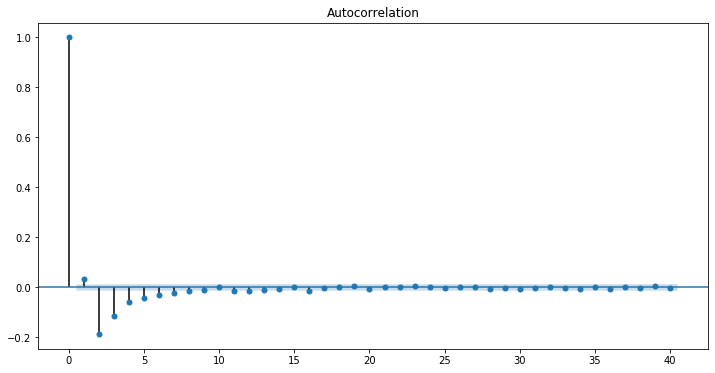

In [19]:
print(plot_acf(df_train['pct_stationary'], lags=40))

### Feature Engineer second model with 10 time lags

In [20]:
print('4. Feature Engineering...\n')
X_train_fe = func.feature_engineer_Kelvin10(df_train)
X_test_fe = func.feature_engineer_Kelvin10(df_test)

4. Feature Engineering...



/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['t-1 K'] = data['Kelvin'].shift(1)
/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['t-2 K'] = data['Kelvin'].shift(2)
/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:80: SettingWithCopyWarning: 
A value i

In [21]:
X_train_fe.head(12)

,t-1 K,t-2 K,t-3 K,t-4 K,t-5 K,t-6 K,t-7 K,t-8 K,t-9 K,t-10 K
DATE,,,,,,,,,,
1950-01-11,270.75,278.75,280.15,278.35,275.45,270.15,273.05,276.05,274.15,269.65
1950-01-12,265.85,270.75,278.75,280.15,278.35,275.45,270.15,273.05,276.05,274.15
1950-01-13,273.15,265.85,270.75,278.75,280.15,278.35,275.45,270.15,273.05,276.05
1950-01-14,275.35,273.15,265.85,270.75,278.75,280.15,278.35,275.45,270.15,273.05
1950-01-15,278.05,275.35,273.15,265.85,270.75,278.75,280.15,278.35,275.45,270.15
1950-01-16,279.85,278.05,275.35,273.15,265.85,270.75,278.75,280.15,278.35,275.45
1950-01-17,277.95,279.85,278.05,275.35,273.15,265.85,270.75,278.75,280.15,278.35
1950-01-18,274.95,277.95,279.85,278.05,275.35,273.15,265.85,270.75,278.75,280.15
1950-01-19,267.75,274.95,277.95,279.85,278.05,275.35,273.15,265.85,270.75,278.75


### Fit model

In [22]:
m = LinearRegression()
m.fit(X_train_fe, df_train['Kelvin'][10:])
#m.score(X_train_fe.dropna(), df_train['Kelvin'][3:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Make predictions

In [23]:
y_pred = m.predict(X_test_fe.dropna())

In [24]:
results10 = zip(df_test['Kelvin'][3:], y_pred)
results10 = pd.DataFrame(results10)
results10.columns = ['True Kelvin', 'pred']
results10.head()

,True Kelvin,pred
0,275.25,274.987278
1,279.25,276.128772
2,275.45,278.380821
3,276.45,279.117494
4,277.95,275.391545


In [25]:
m.coef_

array([ 0.98166622, -0.21164493,  0.08170911,  0.01777334,  0.01341773,
        0.01742565,  0.01066214,  0.0192736 ,  0.00497375,  0.03879032])

### Score model

In [26]:
rmse = np.sqrt(mean_squared_error(results10['True Kelvin'], results10['pred']))
rmse

3.998705019535732

## Feature Engineer 3rd final model with 6 time lags

In [34]:
X_train_fe = func.feature_engineer_Kelvin6(df_train)
X_test_fe = func.feature_engineer_Kelvin6(df_test)
X_train_fe.head(6)

4. Feature Engineering...



/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['t-1 K'] = data['Kelvin'].shift(1)
/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['t-2 K'] = data['Kelvin'].shift(2)
/Users/rjt.weber/Documents/Work/SPICED/repo/logistic-lemongrass-student-code/week_05/functions.py:47: SettingWithCopyWarning: 
A value i

,t-1 K,t-2 K,t-3 K,t-4 K,t-5 K,t-6 K
DATE,,,,,,
1950-01-07,275.45,270.15,273.05,276.05,274.15,269.65
1950-01-08,278.35,275.45,270.15,273.05,276.05,274.15
1950-01-09,280.15,278.35,275.45,270.15,273.05,276.05
1950-01-10,278.75,280.15,278.35,275.45,270.15,273.05
1950-01-11,270.75,278.75,280.15,278.35,275.45,270.15
1950-01-12,265.85,270.75,278.75,280.15,278.35,275.45


### Fit final model

In [35]:
m = LinearRegression()
m.fit(X_train_fe, df_train['Kelvin'][6:])
#m.score(X_train_fe.dropna(), df_train['Kelvin'][3:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Make predictions

In [36]:
y_pred = m.predict(X_test_fe.dropna())
results6 = zip(df_test['Kelvin'][6:], y_pred)
results6 = pd.DataFrame(results6)
results6.columns = ['True Kelvin', 'pred']
results6.head()

,True Kelvin,pred
0,276.45,275.093300
1,277.95,276.947298
2,275.35,277.877934
3,274.35,275.164333
4,275.65,275.112587


### Score final model

In [37]:
rmse = np.sqrt(mean_squared_error(results6['True Kelvin'], results6['pred']))
rmse

2.203184813258308

### Are autocorrelations of detrended + deseasonlized temperatures a measure of predictability?

### January

Figure(864x432)


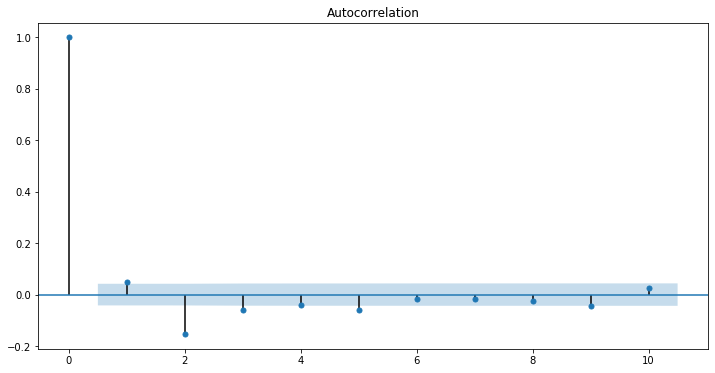

In [28]:
print(plot_acf(df_train[df_train['month'] == 1]['pct_stationary'], lags=10))

### March

Figure(864x432)


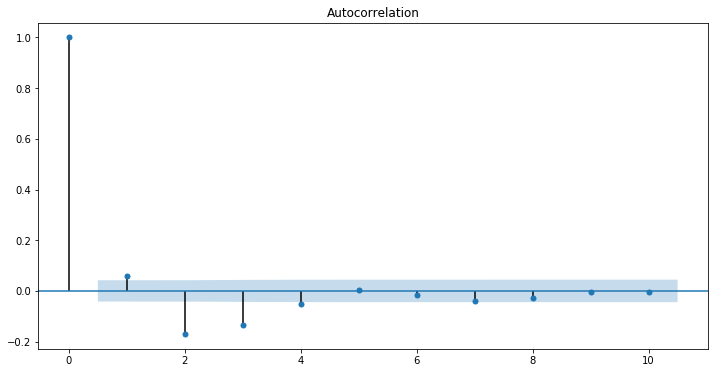

In [29]:
print(plot_acf(df_train[df_train['month'] == 3]['pct_stationary'], lags=10))

### May

Figure(864x432)


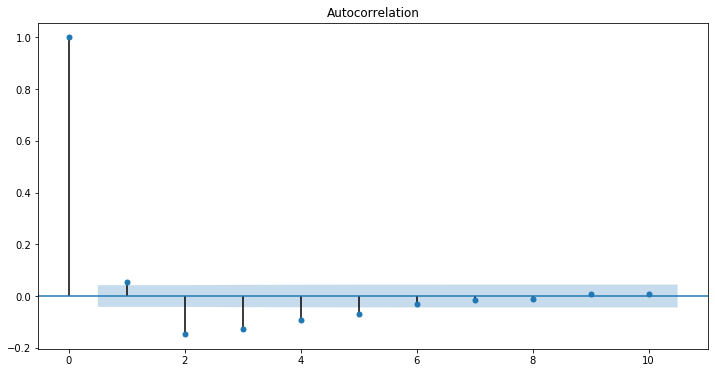

In [30]:
print(plot_acf(df_train[df_train['month'] == 5]['pct_stationary'], lags=10))

### August

Figure(864x432)


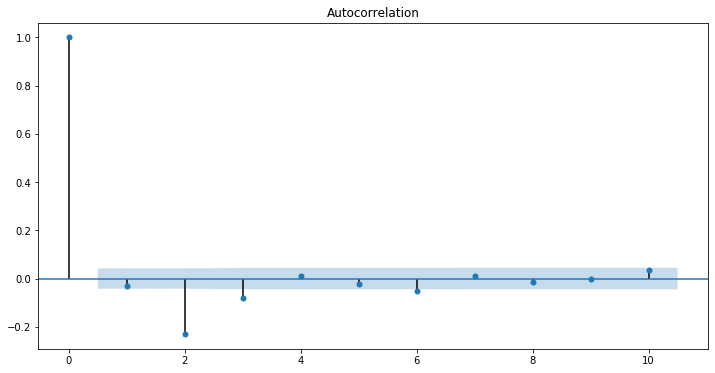

In [31]:
print(plot_acf(df_train[df_train['month'] == 8]['pct_stationary'], lags=10))

### December

Figure(864x432)


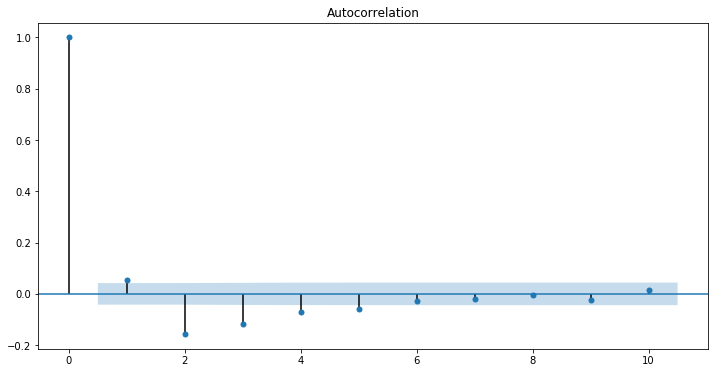

In [32]:
print(plot_acf(df_train[df_train['month'] == 12]['pct_stationary'], lags=10))

### Conclusions
- No added value by adding time lags indefinately
- Time lags should likely correspond to white noise predictability 
    - physical restraints, e.g. chaotic atmosphere 
    - rate of error growth
- Predictability itself can be time and location dependent
- Accuracy of the initial condition (observation) also plays a role